## Especificación y plantilla
Se definen las especificaciones del filtro, su plantilla y luego se normaliza para ver las características del filtro pasabajos
normalizado para el cálculo con aproximación Chebyshev II.

In [8]:
# Definimos los parámetros de la plantilla sin normalizar
aa = 49
ap = 0.5
fp = 3500
fa = 5250

# Obteniendo la plantilla normalizada
wpn = 1
wan = fa / fp

## Cálculo de parámetros
Se calcula el parámetro o factor epsilon para la transferencia y luego, además, el mínimo orden necesario para cumplir con la selectividad planteada utilizando la aproximación de Chebyshev II.

In [9]:
from numpy import arccosh, sqrt, ceil

# Se calcula el minimo orden necesario para la plantilla normalizada con Chebyshev II
# y su respectivo factor epsilon de la función
epsilon = 1 / sqrt(10 ** (aa / 10) - 1)
n = int(ceil(arccosh(sqrt(10**(aa/10) - 1) / sqrt(10**(ap/10) - 1)) / arccosh(wan)))

print(f'Chebyshev II: Orden {n} con Epsilon {epsilon}')

Chebyshev II: Orden 8 con Epsilon 0.003548156226726241


## Cálculo de polos y ceros de $|H(j \omega)|^{2}$
Se calculan los polos y ceros a partir de los parámetros alfa y beta utilizando los cálculos anteriores, y luego se grafican los polos y los ceros resultantes. Los resultados ya se encuentran desnormalizados al multiplicar por la frecuencia de banda atenuante.

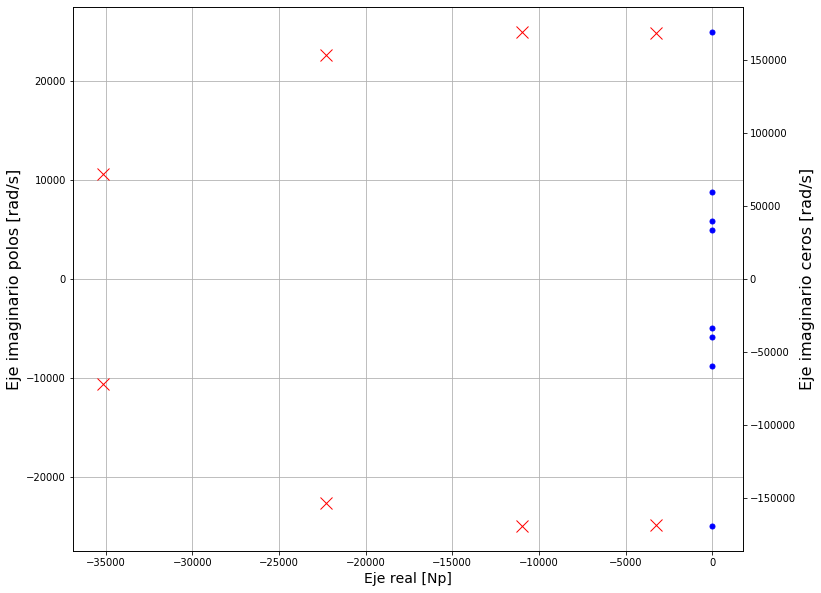

In [10]:
%matplotlib inline

from numpy import arcsinh, pi, sin, cos, sinh, cosh, conj
from matplotlib import pyplot

pyplot.rcParams["figure.figsize"] = (12, 10)

# Calculo los parámetros alfa y beta que permiten
# construir los polos y ceros de la aproximación
alpha = [((2 * k - 1) * pi) / (2 * n) for k in range(1, n + 1, 1)]

# Calculo todos los polos y los ceros
a = sinh( (1 / n) * arcsinh(1 / epsilon) )
b = cosh( (1 / n) * arcsinh(1 / epsilon) )

sigma = -sin([(2*k - 1) * pi / (2 * n) for k in range(1, n + 1, 1)]) * a
omega = cos([(2*k - 1) * pi / (2 * n) for k in range(1, n + 1, 1)]) * b
poles = 2 * pi * fa / (sigma + omega * 1j)
zeros = 2 * pi * fa * 1j / cos([(2*k - 1) * pi / (2 * n) for k in range(1, n + 1, 1)])

# Grafico el diagrama de polos y ceros normalizado
def plot_zp(poles, zeros):
    fig, (ax1) = pyplot.subplots(1, 1)
    ax2 = ax1.twinx()

    for pole, zero in zip(poles, zeros):
        ax1.plot(pole.real, pole.imag, 'rx', markersize=12)
        ax2.plot(zero.real, zero.imag, 'bo', markersize=5)
    
    ax1.set_xlabel("Eje real [Np]", fontsize=14)
    ax1.set_ylabel("Eje imaginario polos [rad/s]", fontsize=16)
    ax2.set_ylabel("Eje imaginario ceros [rad/s]", fontsize=16)
    ax1.grid()
    pyplot.savefig("filtro_polos_ceros")
    pyplot.show()

plot_zp(poles, zeros)

## Polos y ceros normalizados
Se calculan los polos y los ceros de la función $H(j \omega)$, expresandolos en término de la frecuencia y el Q de forma polar en el plano de Laplace.

In [11]:
from cmath import phase
from numpy import arctan
from IPython.display import display, HTML
import pandas as pd

def calculate_wo(fpole, spole):
    return abs(fpole)

def calculate_q(fpole, spole):
    return abs(abs(fpole) / (2 * fpole.real))

# Se crea una tabla con los valores de los polos y ceros expresados según su complejo conjugado, 
# utilizando el módulo y el valor Q
pole_fq = []
zero_fq = []
pole_pairs = []
zero_pairs = []

for i, first_pole in enumerate(poles):
    for second_pole in poles[i + 1:]:
        if round(first_pole.real, 5) == round(second_pole.real, 5):
            pole_pairs.append([first_pole, second_pole])
            pole_fq.append(
                {
                    "wo": calculate_wo(first_pole, second_pole), 
                    "Q": calculate_q(first_pole, second_pole)
                }
            )
            break

for zero in zeros:
    if zero.imag > 0:
        zero_pairs.append([zero, -zero])
        zero_fq.append(
            {
                "wz": zero.imag
            }
        )

# Imprimimos la información
display(HTML(pd.DataFrame(pole_fq).to_html()))
display(HTML(pd.DataFrame(zero_fq).to_html()))

,wo,Q
0,25069.290686,3.844518
1,27292.629248,1.240039
2,31769.359416,0.711811
3,36708.428458,0.522252


,wz
0,33632.970969
1,39672.794260
2,59374.532511
3,169084.363190


## Agrupamiento de polos y ceros
Para el diseño de cada una de las etapas de segundo orden, se busca a continuación agrupar polos y ceros de transmisión de forma tal que el sobrepico en cada una de ellas sea el menor posible para garantizar mayor estabilidad frente a la presencia de ruido, además de maximizar el rango dinámico evitando superar rangos de la señal.

In [12]:
# Agrupamos polos y ceros según la menor distancia proyectada sobre el eje imaginario en donde se observa la respuesta
# en frecuencia. De entre todas las posibles combinaciones, buscamos la de menor distancia total.
stages = []
zeros_used = []

# Para cada polo le asigno un cero con el cual tenga la menor distancia posible
for fpole, spole in pole_pairs:
    distance = 0
    zero_target = None
    for fzero, szero in zero_pairs:
        if fzero not in zeros_used and szero not in zeros_used:
            current_distance = abs(abs(fzero) - abs(fpole.imag))
            if distance == 0 or current_distance < distance:
                distance = current_distance
                zero_target = [fzero, szero]
    
    if zeros is not None:
        stages.append(
            {
                "poles": [fpole, spole],
                "zeros": zero_target
            }
        )
        zeros_used += zero_target

# Realizamos un ordenamiento de Q menor a mayor para así evitar que se produzcan posibles saturaciones de la entrada
stages.sort(key=lambda stage: calculate_q(stage["poles"][0], stage["poles"][1]))

# Representamos de una forma amigable
display(HTML(pd.DataFrame(stages).to_html()))

,poles,zeros
0,"[(-35144.37986433153-10601.00390598563j), (-35144.37986433154+10601.003905985624j)]","[169084.3631903267j, (-0-169084.3631903267j)]"
1,"[(-22315.861559615896-22611.822583750876j), (-22315.861559615907+22611.822583750873j)]","[59374.53251122788j, (-0-59374.53251122788j)]"
2,"[(-11004.74746006294-24975.65103440634j), (-11004.747460062936+24975.651034406335j)]","[39672.79426044738j, (-0-39672.79426044738j)]"
3,"[(-3260.394701675936-24856.370649794237j), (-3260.3947016759416+24856.370649794237j)]","[33632.97096906979j, (-0-33632.97096906979j)]"


[169084j, (-0-169084j), 59374j, (-0-59374j), 39672j, (-0-39672j), 33632j, (-0-33632j)]
[(-35144-10601j), (-35144+10601j), (-22315-22611j), (-22315+22611j), (-11004-24975j), (-11004+24975j), (-3260-24856j), (-3260+24856j)]
0.00354787141836514


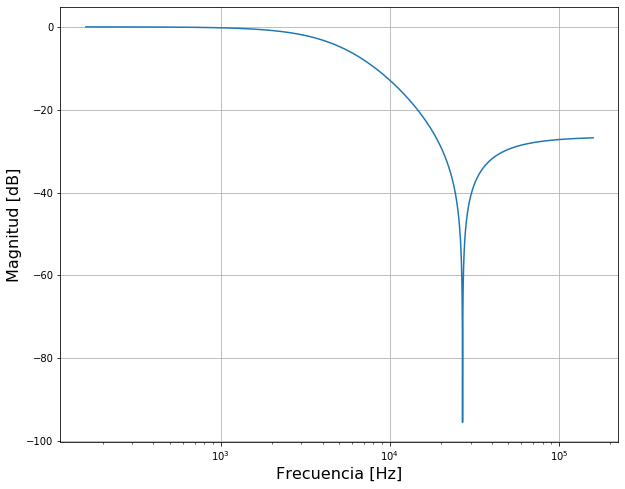

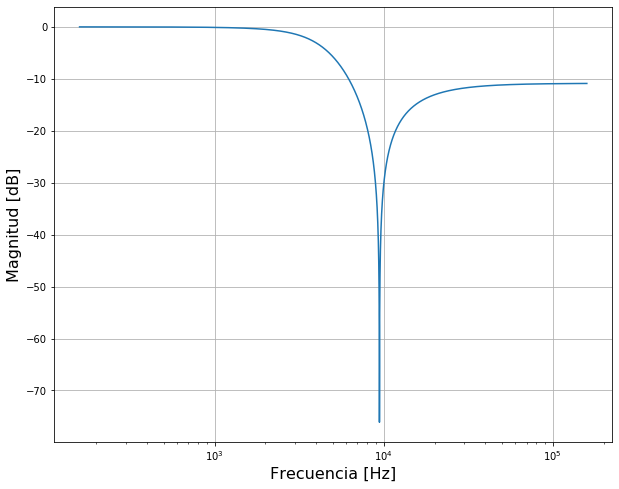

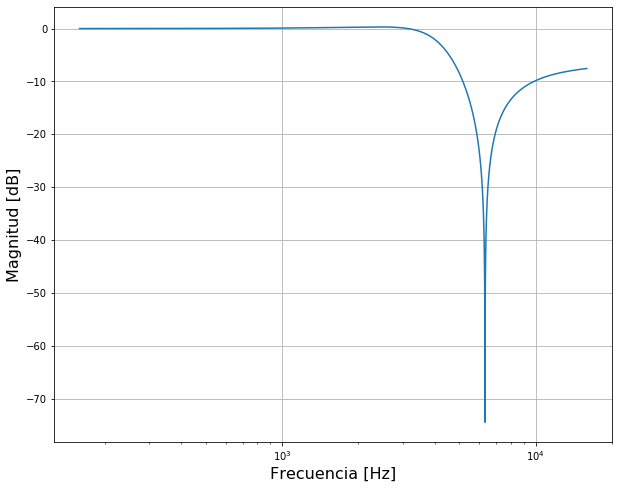

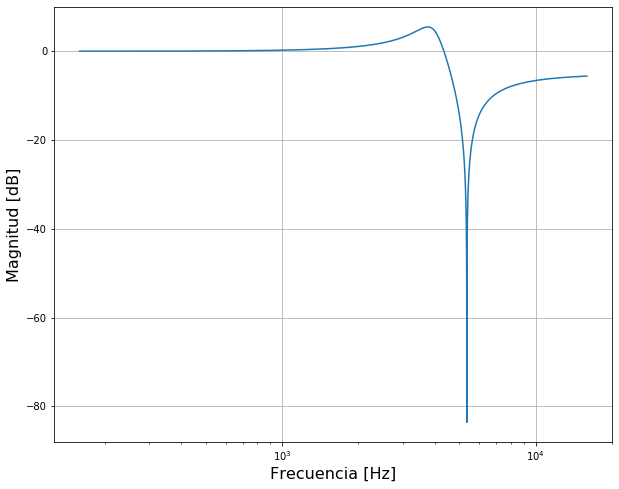

In [23]:
%matplotlib inline

from scipy import signal
from matplotlib import pyplot
from numpy import arange

pyplot.rcParams["figure.figsize"] = (10,8)

# Calculando la corrección de la ganancia de banda pasante
def unity_gain(zeros, poles):
    gain = 1
    for zero, pole in zip(zeros, poles):
        gain = gain * (-zero) / (-pole)
    return 1 / gain

poles = [
    -35144-10601j, 
    -35144+10601j,
    -22315-22611j,
    -22315+22611j,
    -11004-24975j,
    -11004+24975j,
    -3260-24856j,
    -3260+24856j
]

zeros = [
    169084j, 
    -169084j,
    59374j,
    -59374j,
    39672j,
    -39672j,
    33632j,
    -33632j
]

gain = unity_gain(zeros, poles)

# Calculando y graficando la respuesta en frecuencia de cada sistema
for stage in stages:
    stage["h"] = signal.lti(stage["zeros"], stage["poles"], unity_gain(stage["zeros"], stage["poles"]))

for i, stage in enumerate(stages):
    w, mag, phase = stage["h"].bode(n=10000)
    pyplot.figure()
    pyplot.semilogx(w / (2 * pi), mag)
    pyplot.xlabel("Frecuencia [Hz]", fontsize=16)
    pyplot.ylabel("Magnitud [dB]", fontsize=16)
    pyplot.grid()
    pyplot.savefig(f'etapa_{i+1}')
pyplot.show()

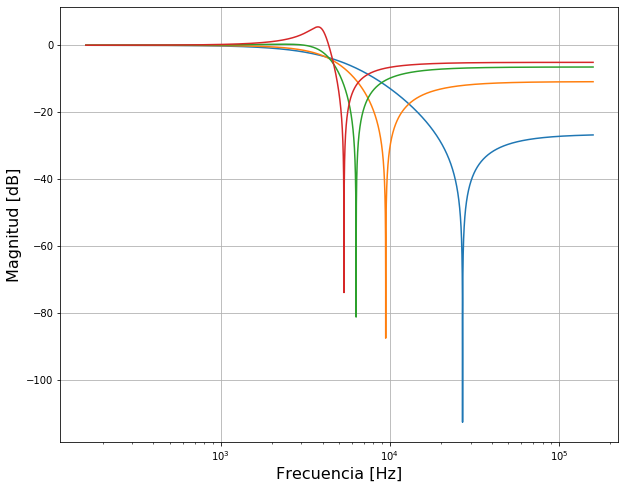

In [14]:
pyplot.rcParams["figure.figsize"] = (10,8)

# Graficando otro para poder analizar superposición de picos
for stage in stages:
    w, mag, phase = stage["h"].bode(arange(1e3, 1000e3, 0.01e3))
    pyplot.semilogx(w / (2 * pi), mag)
pyplot.xlabel("Frecuencia [Hz]", fontsize=16)
pyplot.ylabel("Magnitud [dB]", fontsize=16)
pyplot.grid()
pyplot.savefig("etapas_superpuestas")
pyplot.show()

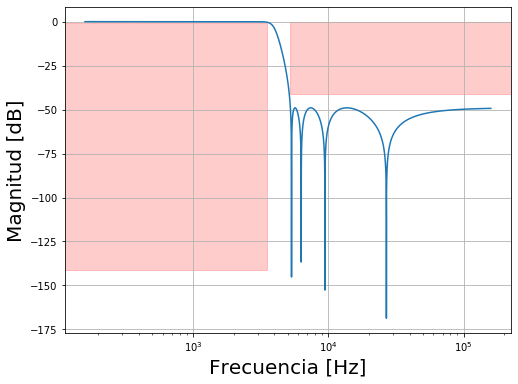

In [15]:
%matplotlib inline

from scipy import signal
from matplotlib import pyplot

pyplot.rcParams["figure.figsize"] = (8,6)

# Calculando y graficando la respuesta en frecuencia
h = signal.lti(zeros, poles, unity_gain(zeros, poles))
w, mag, phase = h.bode(n=1000000)

pyplot.semilogx(w / (2 * pi), mag)
pyplot.gca().add_patch(pyplot.Rectangle((1, -1), 3.5e3, -140, fill=True, edgecolor=None, color='red', alpha=0.2))
pyplot.gca().add_patch(pyplot.Rectangle((5.25e3, 0), 1e7, -41, fill=True, edgecolor=None, color='red', alpha=0.2))
pyplot.xlabel("Frecuencia [Hz]", fontsize=20)
pyplot.ylabel("Magnitud [dB]", fontsize=20)
pyplot.grid()
pyplot.savefig("filtro_respuesta")
pyplot.show()

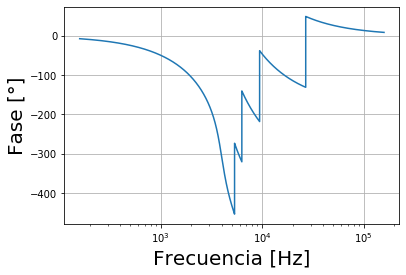

In [16]:
%matplotlib inline

pyplot.semilogx(w / (2 * pi), phase)
pyplot.xlabel("Frecuencia [Hz]", fontsize=20)
pyplot.ylabel("Fase [°]", fontsize=20)
pyplot.grid()
pyplot.show()

### Función Transferencia

\begin{equation}
    H_{LP}(s) = \frac{\left(\frac{s}{\omega_c}\right)^{2} + 1}{\left(\frac{s}{\omega_o}\right)^{2} + \frac{1}{Q \cdot \omega_o} \cdot s + 1}
\end{equation}

\begin{equation}
    H(s) = \frac{1}{256} \cdot 
    \frac{\left(\frac{s}{2\pi \cdot 4804710}\right)^{2} + 1}{\left(\frac{s}{2 \pi \cdot 3616020}\right)^{2} + \frac{1}{3.89 \cdot 2 \pi \cdot 3616020} \cdot s + 1} \cdot 
    \frac{\left(\frac{s}{2\pi \cdot 5667542}\right)^{2} + 1}{\left(\frac{s}{2 \pi \cdot 3943834}\right)^{2} + \frac{1}{1.25 \cdot 2 \pi \cdot 3943834} \cdot s + 1} \cdot 
    \frac{\left(\frac{s}{2\pi \cdot 8482076}\right)^{2} + 1}{\left(\frac{s}{2 \pi \cdot 4609715}\right)^{2} + \frac{1}{0.716 \cdot 2 \pi \cdot 4609715} \cdot s + 1} \cdot 
    \frac{\left(\frac{s}{2\pi \cdot 24154909}\right)^{2} + 1}{\left(\frac{s}{2 \pi \cdot 5354832}\right)^{2} + \frac{1}{0.522 \cdot 2 \pi \cdot 5354832} \cdot s + 1}
\end{equation}

## Diseño de las celdas Sedra

![title](sedra.png)

In [17]:
# Procedo a definir las ecuaciones o funciones para poder obtener,
# a partir de las necesidades de una etapa de segundo orden, los parámetros
# para implementar el filtro pasabajos con ceros de transmisión
# usando la celda Sedra
norm = [1, 1.2, 1.5, 1.8, 2.2, 2.7, 3.3, 3.9, 4.3, 4.7, 5.1, 5.6, 6.8, 8.2]

def calc_n2(ga1, ga2, gb, c41, c42):
    return ((ga1 + ga2 + gb) / gb) * (c42 / (c41 + c42)) - (ga2 / gb)

def calc_k(n2, qo, q):
    return n2 / (1 - qo / q)

def calc_K(qo, q):
    return 1 + (1 - qo / q) / (2 * qo **2)

def calc_n(k, K, qo, q):
    return k * (1 - qo / (K * q))

def calc_m(k, K, qo, wz, wo):
    return k * ((K-1) / K) * (1 + 2 * (qo ** 2) * ((wz / wo) ** 2))
                             
def calc_wp(wo, qo, wt):
    return wo * (1 + qo * (wo / wt))

def calc_qp(q, qo, wo, wt):
    return q * (1 - 2 * qo * q * (wo / wt) * ( 1 / (2 * q) - wo / wt))

def calc_c41_c42(c41, n):
    return c41, (c41 * n) / (1 - n)

def calc_c1(qo, c41, c42):
    return 4 * (qo**2) * (c41 + c42)

def calc_g3(wp, c1, c41, c42):
    return wp * sqrt(c1 * (c41 + c42))

def calc_ga(gb, c1, c41, c42, g3, wp, qp, k):
    return gb * (((c41 + c42) / c1) * 2 - (wp * (c41 + c42)) / (qp * g3))

def calc_ga1_ga2(ga, gb, c41, c42, c1, g3):
    ga2 = ((ga + gb) * (c42 / (c41 + c42)) * ((2 * g3) / c1)) / (g3 / (c41 + c42) + (2 * g3) / c1)
    return ga - ga2, ga2

def calc_g22(n0, c1, c41, c42, ga1, ga2, gb, g3):
    return (((n0 * c1 * (c41 + c42)) / g3 + (g3 * ga2) / gb) * gb) / (ga1 + ga2 + gb)
    
def sedra_lpnotch(n2, qo, q, wo, wz, wt, c41, gb):
    k = calc_k(n2, qo, q)
    K = calc_K(qo, q)
    n = calc_n(k, K, qo, q)
    m = calc_m(k, K, qo, wz, wo)
    
    c41, c42 = calc_c41_c42(c41, n)
    c1 = calc_c1(qo, c41, c42)
    
    wp = calc_wp(wo, qo, wt)
    qp = calc_qp(q, qo, wo, wt)
    
    g21_g22 = g3 = calc_g3(wp, c1, c41, c42)
    ga1_ga2 = calc_ga(gb, c1, c41, c42, g3, wp, qp, k)
    
    ga1, ga2 = calc_ga1_ga2(ga1_ga2, gb, c41, c42, c1, g3)
    n2 = calc_n2(ga1, ga2, gb, c41, c42)
    g22 = calc_g22(n2 * wz * wz, c1, c41, c42, ga1, ga2, gb, g3)
    g21 = g3 - g22

    result = {
        "k": k,
        "K": K,
        "n": n,
        "m": m,
        "wp": wp,
        "qp": qp,
        "c1": c1,
        "c41": c41,
        "c42": c42,
        "r3": 1 / g3,
        "r21": 1 / g21,
        "r22": 1 / g22,
        "ra1": 1 / ga1,
        "ra2": 1 / ga2,
        "rb": 1 / gb
    }
    
    for key in result.keys():
        if "r" in key:
            result[key] = int(result[key])
    
    return result

def sedra_h(ga1, ga2, gb, g21, g22, g3, c1, c41, c42):
    wo = sqrt( (g3 * (g21 + g22)) / (c1 * (c41 + c42)))
    q = wo / (((g21 + g22 + g3) / c1) - (g3 / (c41 + c42)) * ((ga1 + ga2) / gb))
    n2 = ((ga1 + ga2 + gb) / gb) * (c42 / (c41 + c42)) - (ga2 / gb)
    n1 = ((ga1 + ga2 + gb) / gb) * (c42 / (c41 + c42)) * ((g21 + g22 + g3) / c1) - (ga2 / gb) * ((g3 / (c41 + c42)) + ((g21 + g22 + g3) / c1))
    n0 = ((g3 * (g21 + g22)) / (c1 * (c41 + c42))) * ((g22 / (g21 + g22)) * ((ga1 + ga2 + gb) / gb) - ga2 / gb)
    
    return {
        "wo": wo,
        "q": q,
        "n2": n2,
        "n1": n1,
        "n0": n0
    }

## Cálculo de celdas y etapas
Se calcula para cada etapa los parámetro de la celda correspondiente.

In [18]:
# Ejecuto las funciones para computar los valores de resistencias y capacitores para la celda
# acorde a las caracteristicas de cada etapa
cells = [
    sedra_lpnotch(
        (calculate_wo(stages[0]["poles"][0], stages[0]["poles"][1]) / abs(stages[0]["zeros"][0]))**2, 
        calculate_q(stages[0]["poles"][0], stages[0]["poles"][1]) * 0.95, 
        calculate_q(stages[0]["poles"][0], stages[0]["poles"][1]), 
        calculate_wo(stages[0]["poles"][0], stages[0]["poles"][1]), 
        abs(stages[0]["zeros"][0]),
        450e6 * 2 * pi,
        100e-9,
        1 / 200
    ),
    sedra_lpnotch(
        (calculate_wo(stages[1]["poles"][0], stages[1]["poles"][1]) / abs(stages[1]["zeros"][0]))**2, 
        calculate_q(stages[1]["poles"][0], stages[1]["poles"][1]) * 0.71, 
        calculate_q(stages[1]["poles"][0], stages[1]["poles"][1]), 
        calculate_wo(stages[1]["poles"][0], stages[1]["poles"][1]), 
        abs(stages[1]["zeros"][0]),
        400e6 * 2 * pi,
        100e-9,
        1 / 1000
    ),
    sedra_lpnotch(
        (calculate_wo(stages[2]["poles"][0], stages[2]["poles"][1]) / abs(stages[2]["zeros"][0]))**2, 
        calculate_q(stages[2]["poles"][0], stages[2]["poles"][1]) * 0.45, 
        calculate_q(stages[2]["poles"][0], stages[2]["poles"][1]), 
        calculate_wo(stages[2]["poles"][0], stages[2]["poles"][1]), 
        abs(stages[2]["zeros"][0]),
        450e6 * 2 * pi,
        1e-9,
        1 / 10000
    ),
    sedra_lpnotch(
        (calculate_wo(stages[3]["poles"][0], stages[3]["poles"][1]) / abs(stages[3]["zeros"][0]))**2, 
        calculate_q(stages[3]["poles"][0], stages[3]["poles"][1]) * 0.41, 
        calculate_q(stages[3]["poles"][0], stages[3]["poles"][1]), 
        calculate_wo(stages[3]["poles"][0], stages[3]["poles"][1]), 
        abs(stages[3]["zeros"][0]),
        450e6 * 2 * pi,
        10e-9,
        1 / 1000
    )
]

# Visualizamos la data
display(HTML(pd.DataFrame(cells).to_html()))

,k,K,n,m,wp,qp,c1,c41,c42,r3,r21,r22,ra1,ra2,rb
0,0.942659,1.101562,0.129699,0.994713,36708.664910,0.522248,1.131352e-07,1.000000e-07,1.490279e-08,238,45094,240,34409,2089,200
1,0.987230,1.567704,0.540122,0.995376,31769.562371,0.711807,2.221588e-07,1.000000e-07,1.174489e-07,143,30915,143,138051,1784,1000
2,0.860483,1.883155,0.654862,0.934570,27292.776257,1.240032,3.608797e-09,1.000000e-09,1.897389e-09,11330,173162,12124,81160,13158,10000
3,0.941676,1.118733,0.596565,0.993810,25069.641048,3.844464,2.463417e-07,1.000000e-08,1.478714e-08,510,82135,513,144427,8943,1000
